In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [2]:
import xgboost
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
df = pd.read_csv('D:/Resume_matcher/data/fake_job_postings.csv')
df.shape
df.head()

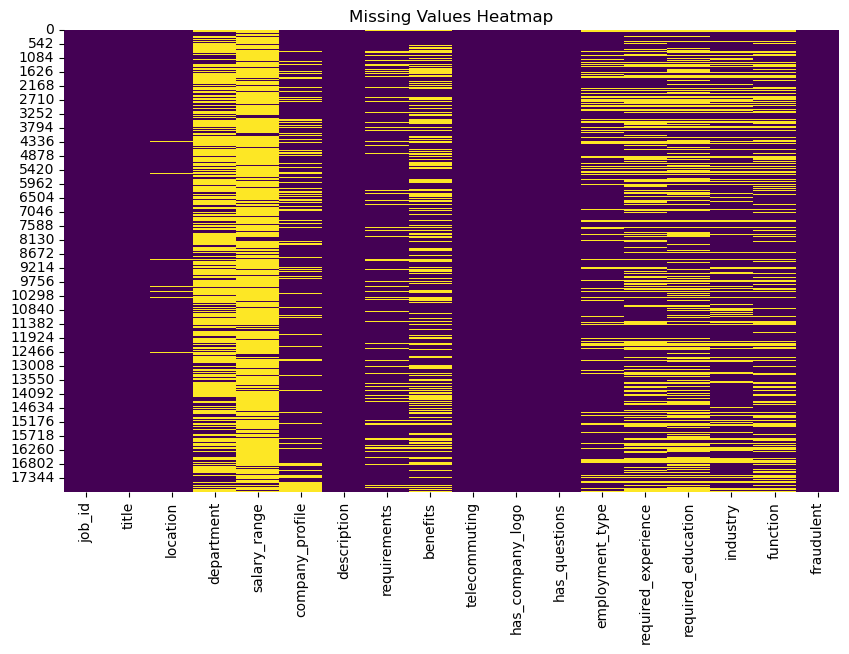

In [ ]:
df.isnull().sum().sort_values(ascending=False)

# Visualize missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
# Fill missing with a placeholder or strategy
df.fillna("missing", inplace=True)

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Feature matrix and target
X = df.drop(columns=['fraudulent', 'job_id'])  # drop ID & target
y = df['fraudulent']

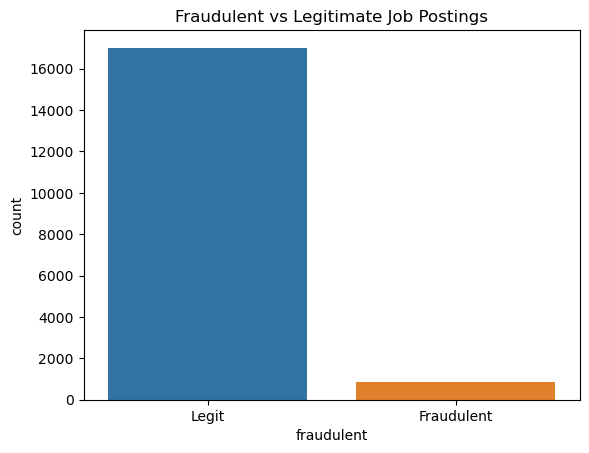

Fraudulent postings: 4.84%


In [ ]:
sns.countplot(data=df, x='fraudulent')
plt.title('Fraudulent vs Legitimate Job Postings')
plt.xticks([0, 1], ['Legit', 'Fraudulent'])
plt.show()

fraud_pct = df['fraudulent'].value_counts(normalize=True)[1] * 100
print(f"Fraudulent postings: {fraud_pct:.2f}%")

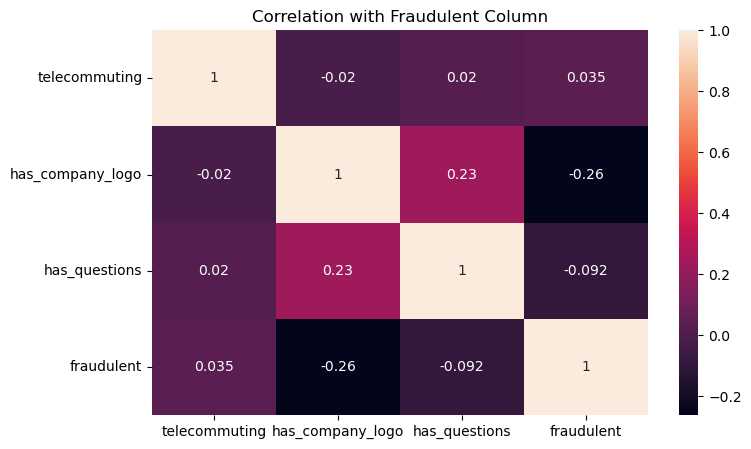

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].corr(), annot=True)
plt.title("Correlation with Fraudulent Column")
plt.show()

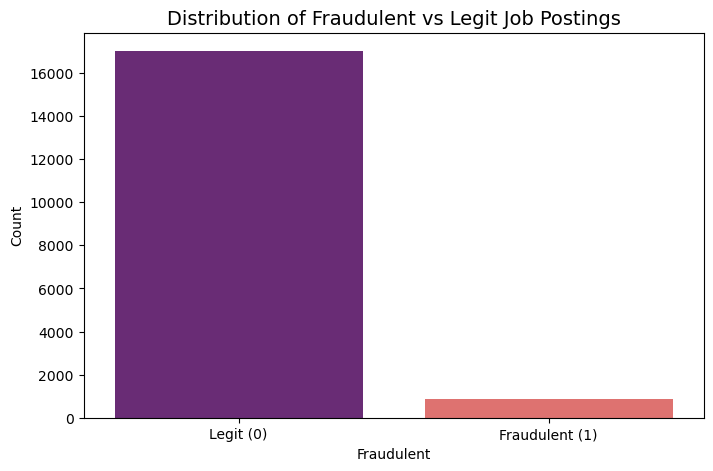

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='fraudulent', data=df, palette='magma')
plt.title("Distribution of Fraudulent vs Legit Job Postings", fontsize=14)
plt.xticks([0, 1], ['Legit (0)', 'Fraudulent (1)'])
plt.xlabel("Fraudulent")
plt.ylabel("Count")
plt.show()

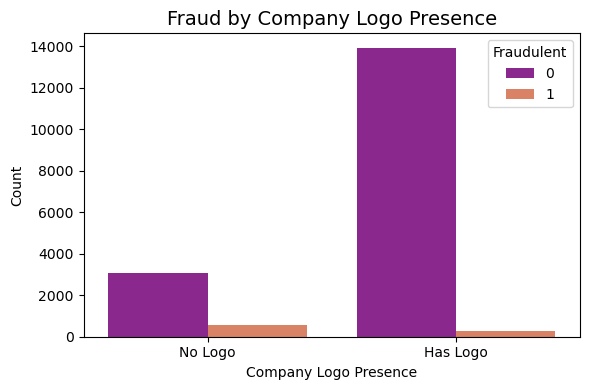

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='plasma')
plt.title('Fraud by Company Logo Presence', fontsize=14)
plt.xticks([0,1], ['No Logo', 'Has Logo'])
plt.xlabel('Company Logo Presence')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

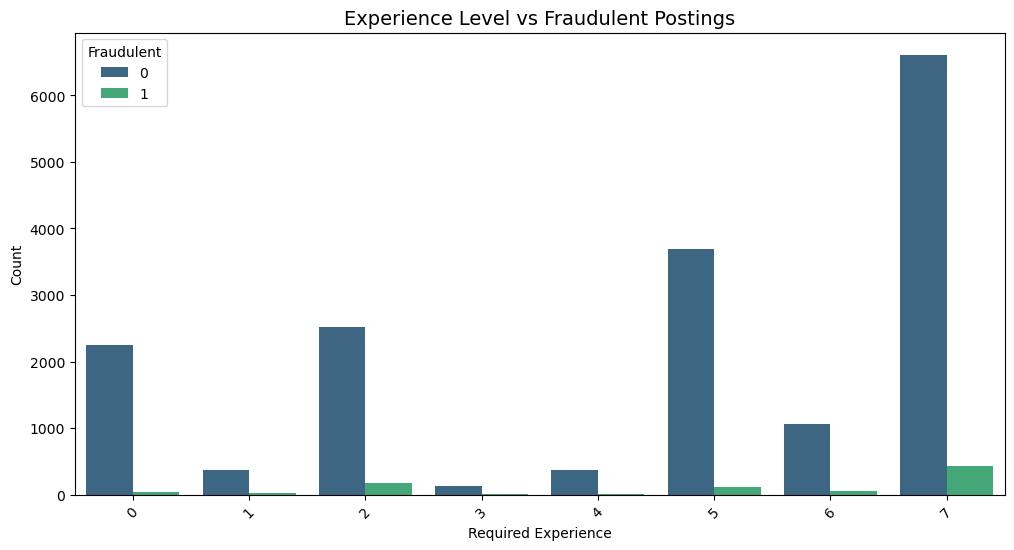

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='required_experience', hue='fraudulent', palette='viridis')
plt.title("Experience Level vs Fraudulent Postings", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Required Experience")
plt.ylabel("Count")
plt.legend(title="Fraudulent")
plt.show()

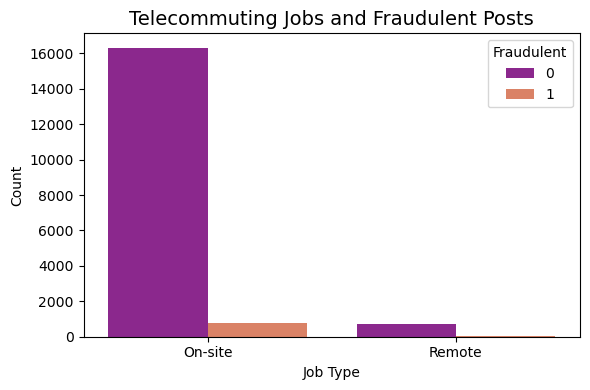

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='telecommuting', hue='fraudulent', palette='plasma')
plt.title('Telecommuting Jobs and Fraudulent Posts', fontsize=14)
plt.xticks([0,1], ['On-site', 'Remote'])
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

In [ ]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = "missing"
    return text

text_columns = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'industry', 'function']
for col in text_columns:
    df[col] = df[col].apply(clean_text)

In [ ]:
# Handle missing values
df.fillna("missing", inplace=True)

# Features and target
X = df.drop(columns=['fraudulent', 'job_id'])  # Drop 'job_id' and 'fraudulent'
y = df['fraudulent']

In [ ]:
# Identify categorical columns (object type)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Build preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # Numerical features pass through untouched
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

c:\Users\srush\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Evaluate
print("XGB_Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

XGB_Accuracy: 0.9588926174496645
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.81      0.20      0.32       173

    accuracy                           0.96      3576
   macro avg       0.89      0.60      0.65      3576
weighted avg       0.95      0.96      0.95      3576



In [ ]:
import xgboost as xgb 
from sklearn.impute import SimpleImputer

# Identify categorical columns (object type)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Build preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # Numerical features pass through untouched
)

# Define XGBClassifier model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, enable_categorical=True)

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.4],
    'classifier__reg_alpha': [0, 0.01, 0.1, 1],
    'classifier__reg_lambda': [1, 1.5, 2]
}

# Setup Randomized Search with the model and preprocessing pipeline
random_search = RandomizedSearchCV(
    estimator=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ]),
    param_distributions=param_grid,
    n_iter=30,               # Number of combinations to try
    scoring='accuracy',
    cv=5,                    # 5-fold cross validation
    verbose=2,
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

# Train the model
random_search.fit(X_train, y_train)

# Get Best Model
best_xgb = random_search.best_estimator_

# Print Best Hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'classifier__subsample': 0.6, 'classifier__reg_lambda': 1.5, 'classifier__reg_alpha': 0.01, 'classifier__n_estimators': 500, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.8}


In [ ]:
# Train the model using the best hyperparameters
best_model = random_search.best_estimator_

# Fit the model on the training data
best_model.fit(X_train, y_train)

c:\Users\srush\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['title', 'location',
                                                   'department',
                                                   'company_profile',
                                                   'description',
                                                   'requirements', 'benefits',
                                                   'industry', 'function'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsam...
                               feature_types=None, gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Predictions on test set
y_pred = best_model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9577740492170023
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.71      0.21      0.33       173

    accuracy                           0.96      3576
   macro avg       0.84      0.60      0.65      3576
weighted avg       0.95      0.96      0.95      3576



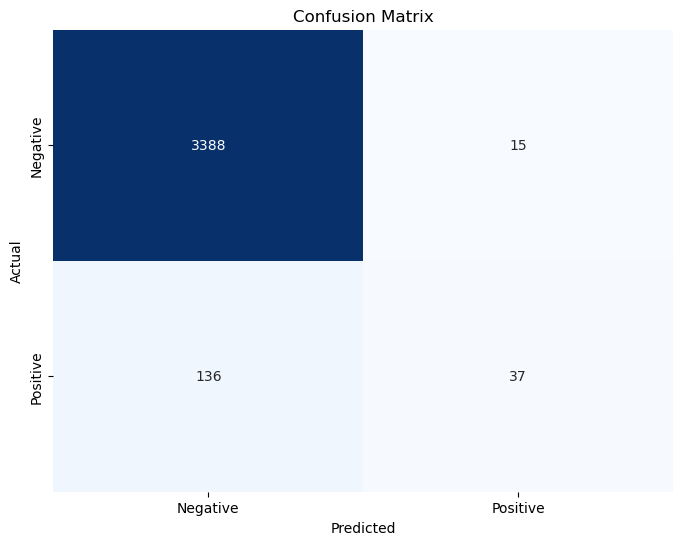

In [ ]:
# Get the predictions
y_pred = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

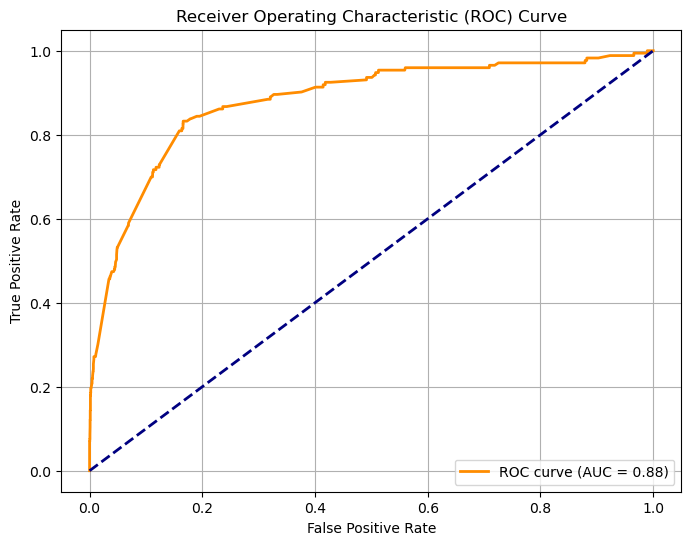

In [ ]:
# Get predicted probabilities for the positive class (class 1)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

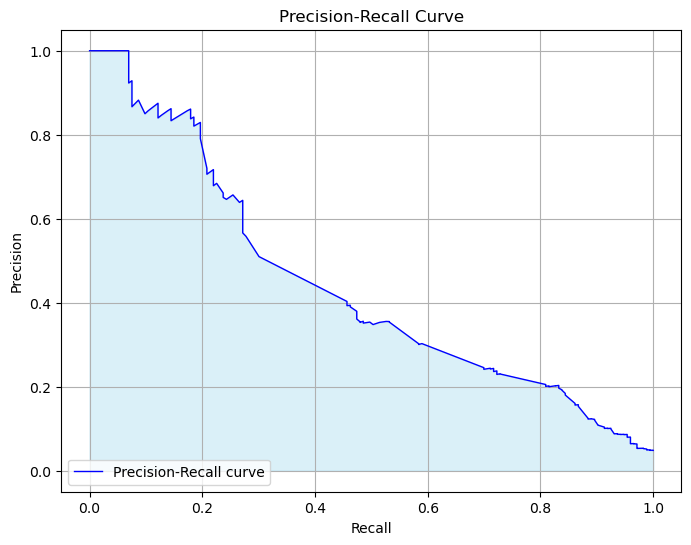

In [ ]:
# Get predicted probabilities for the positive class (class 1)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute Precision and Recall values
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=1, label='Precision-Recall curve')
plt.fill_between(recall, precision, color='skyblue', alpha=0.3)

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
import joblib

# Save model
joblib.dump(xgb_model, 'xgb_fraud_detector.pkl')

['xgb_fraud_detector.pkl']

In [ ]:
def predict_fraud(new_data):
    new_vector = preprocessor.transform(new_data)  # If you used one
    prediction = xgb_model.predict(new_vector)
    return 'Fraudulent' if prediction[0] == 1 else 'Legit'

In [ ]:
import joblib

# Save the trained pipeline
joblib.dump(best_xgb, 'model.joblib')

['model.joblib']

In [ ]:
import joblib

# Load the trained model
model = joblib.load('model.joblib')

# Check the ColumnTransformer's expected columns
preprocessor = model.named_steps['preprocessor']

# Loop through the transformers and find the correct one
for name, transformer, columns in preprocessor.transformers_:
    if isinstance(transformer, OneHotEncoder):
        # Get feature names after encoding
        feature_names = transformer.get_feature_names_out(columns)
        print(f"Columns for {name} transformer:", feature_names)

Columns for cat transformer: ['title_missing' 'location_missing' 'department_missing'
 'company_profile_missing' 'description_missing' 'requirements_missing'
 'benefits_missing' 'industry_missing' 'function_missing']
